# Train model for all glaciers, blocking by glacier


In [121]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from matplotlib import pyplot as plt
import xgboost as xgb

from model_functions import select_variables
from model_functions import train_xgb_model
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_fold


In [122]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_all = data[data['balance_netto'].notna()]
glacier_data_all.reset_index(drop=True, inplace=True)


C:\Users\kasj\AppData\Local\Temp\ipykernel_16244\1510741197.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


Text(0.5, 0, 'glacier id')

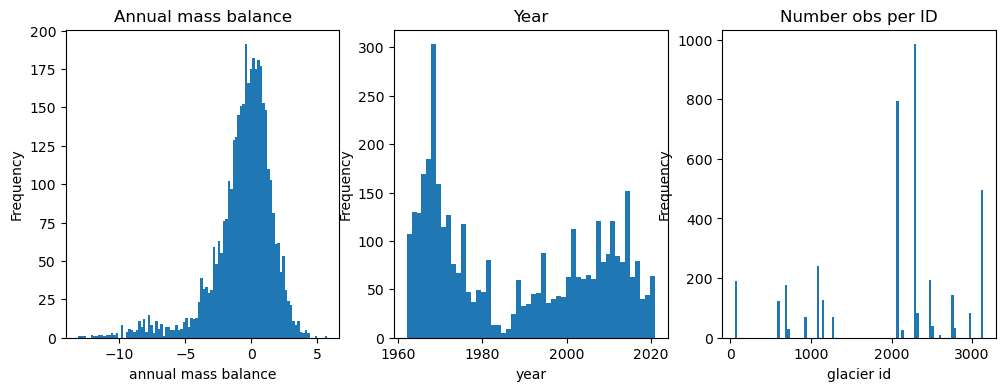

In [123]:
# Plot dataset distributions

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), sharey=False)
glacier_data_all['balance_netto'].plot.hist(bins=100, ax=ax1)
ax1.set_title('Annual mass balance')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('annual mass balance')

glacier_data_all['year'].plot.hist(bins=50, ax=ax2)
ax2.set_title('Year')
ax2.set_xlabel('year')

glacier_data_all['BREID'].plot.hist(bins=100, ax=ax3)
ax3.set_title('Number obs per ID')
ax3.set_xlabel('glacier id')

In [124]:
# Manually select test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2768, 2478, 2769, 3127, 3141]

df_test = glacier_data_all[glacier_data_all['BREID'].isin(test_glaciers)]
# 54 has 189 points
# 703 has 30 points
# 941 has 70 points
# 1280 has 71 points
# 2085 has 163 points
# 2320 has 83 points
# 2768 has 12 points
# 2478 has 89 points
# 2769 has 121 points
# 3127 has 145 points
# 3141 has 72 points
# Test dataset has 1101 points in total, approximately 28% of the data
# Train dataset has 2809 points, approximately 72% of the data

df_train = glacier_data_all[~glacier_data_all['BREID'].isin(test_glaciers)]

Train mass balance: mean -0.5340587397650409, min -13.1, max 5.72.
Test mass balance: mean -0.9395476839237057, min -6.3, max 4.1.
Train altitude: mean 1341.1953364186543, min 190.0, max 2212.0.
Test altitude: mean 1252.8973660308811, min 390.0, max 2105.0.
Train mean temp: mean -1.8242940553922722, min -7.492487335205055, max 3.914905802408896.
Test mean temp: mean -1.3522719052644447, min -7.176125590006507, max 3.888141886393271.
Train prec sum: mean 0.06703014855414581, min 0.026136178523301197, max 0.132155250757932.
Test prec sum: mean 0.06271467678211604, min 0.026136178523301197, max 0.123711260966956.


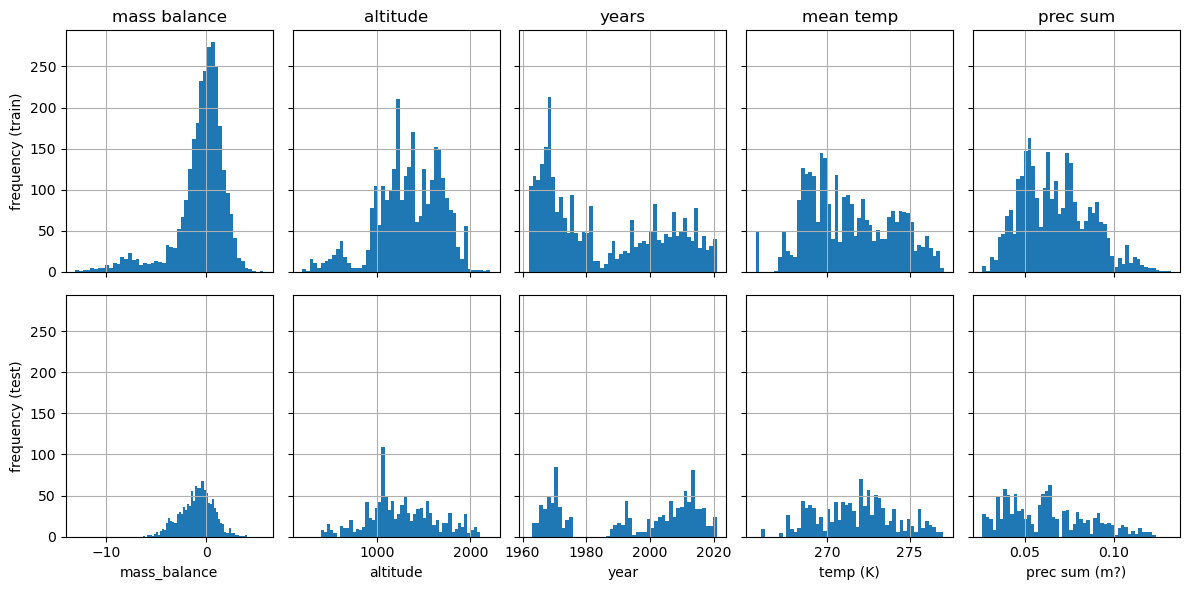

In [39]:
# Number of measurements by topography
temp_cols = ['t2m_oct','t2m_nov','t2m_dec','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_dec','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']

f, ax = plt.subplots(2, 5, figsize=(12,6), sharey=True, sharex='col')
df_train['balance_netto'].plot.hist(bins=50, ax=ax[0,0])
ax[0,0].set_title('mass balance')
ax[0,0].set_ylabel('frequency (train)')
df_train['altitude'].plot.hist(bins=50, ax=ax[0,1])
ax[0,1].set_title('altitude')
df_train['year'].plot.hist(bins=50, ax=ax[0,2])
ax[0,2].set_title('years')
df_train[temp_cols].mean(axis=1).plot.hist(bins=50, ax=ax[0,3])
ax[0,3].set_title('mean temp')
df_train[prec_cols].sum(axis=1).plot.hist(bins=50, ax=ax[0,4])
ax[0,4].set_title('prec sum')

df_test['balance_netto'].plot.hist(bins=50, ax=ax[1,0])
ax[1,0].set_ylabel('frequency (test)')
ax[1,0].set_xlabel('mass_balance')
df_test['altitude'].plot.hist(bins=50, ax=ax[1,1])
ax[1,1].set_xlabel('altitude')
df_test['year'].plot.hist(bins=50, ax=ax[1,2])
ax[1,2].set_xlabel('year')
df_test[temp_cols].mean(axis=1).plot.hist(bins=50, ax=ax[1,3])
ax[1,3].set_xlabel('temp (K)')
df_test[prec_cols].sum(axis=1).plot.hist(bins=50, ax=ax[1,4])
ax[1,4].set_xlabel('prec sum (m?)')

for row in ax:
    for a in row:
        a.grid()

plt.tight_layout()

T_0 = 273.15
print(f"Train mass balance: mean {df_train['balance_netto'].mean()}, min {df_train['balance_netto'].min()}, max {df_train['balance_netto'].max()}.")
print(f"Test mass balance: mean {df_test['balance_netto'].mean()}, min {df_test['balance_netto'].min()}, max {df_test['balance_netto'].max()}.")
print(f"Train altitude: mean {df_train['altitude'].mean()}, min {df_train['altitude'].min()}, max {df_train['altitude'].max()}.")
print(f"Test altitude: mean {df_test['altitude'].mean()}, min {df_test['altitude'].min()}, max {df_test['altitude'].max()}.")
print(f"Train mean temp: mean {df_train[temp_cols].mean().mean()-T_0}, min {df_train[temp_cols].mean(axis=1).min()-T_0}, max {df_train[temp_cols].mean(axis=1).max()-T_0}.")
print(f"Test mean temp: mean {df_test[temp_cols].mean().mean()-T_0}, min {df_test[temp_cols].mean(axis=1).min()-T_0}, max {df_test[temp_cols].mean(axis=1).max()-T_0}.")
print(f"Train prec sum: mean {df_train[prec_cols].sum(axis=1).mean()}, min {df_train[prec_cols].sum(axis=1).min()}, max {df_train[prec_cols].sum(axis=1).max()}.")
print(f"Test prec sum: mean {df_test[prec_cols].sum(axis=1).mean()}, min {df_test[prec_cols].sum(axis=1).min()}, max {df_test[prec_cols].sum(axis=1).max()}.")

# Training with only temperature, precipitation and topographical features

### Select features and prepare data for training

In [6]:
# Select features
base_cols = ['altitude','aspect','slope','altitude_climate']
temp_cols = ['t2m_oct','t2m_nov','t2m_dec','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_dec','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
label_cols = ['balance_netto']

In [7]:
# Shuffle training dataset in order to shuffle glaciers such that they do not appear in order of glacier ID
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [8]:
# Select features for training
df_train_X_s = select_variables(df_train_s, base_cols, temp_cols, prec_cols)

# Select labels for training
df_train_y_s = select_variables(df_train_s, label_cols)

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

In [9]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)
print(gp_s)
print(gp_s.shape)
print(X_train_s.shape)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

[ 596 2297 2297 ... 2297 2297 2474]
(2809,)
(2809, 28)


In [10]:
df_train_X_s

,altitude,aspect,slope,altitude_climate,t2m_oct,t2m_nov,t2m_dec,t2m_jan,t2m_feb,t2m_mar,...,tp_dec,tp_jan,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep
0,1003.0,0.771427,0.162549,1001.181943,269.387421,261.827911,262.573364,265.326019,260.279266,264.112152,...,0.006105,0.012715,0.002994,0.002428,0.001993,0.002906,0.003402,0.003066,0.004062,0.004951
1,1835.0,1.122083,0.084707,1382.210502,272.531006,266.082123,259.900452,262.162689,262.030579,258.754150,...,0.004000,0.008896,0.008417,0.001199,0.001869,0.001849,0.004311,0.001448,0.006092,0.005234
2,1714.0,1.237335,0.054599,1382.210502,270.186035,265.783020,261.203888,258.685822,262.902069,262.054138,...,0.007933,0.004952,0.003765,0.004185,0.001821,0.000777,0.004347,0.002090,0.004416,0.005844
3,1513.0,2.613254,0.095680,1382.210502,268.541718,262.040466,262.056396,263.277100,257.831024,261.003479,...,0.001538,0.005657,0.002251,0.003153,0.003520,0.001913,0.002004,0.007230,0.002486,0.009946
4,1513.0,2.489397,0.100789,1322.716089,273.114014,265.902954,262.492157,261.368622,258.505157,262.151306,...,0.002565,0.001720,0.004909,0.002112,0.004616,0.003036,0.004256,0.005699,0.006093,0.002317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,1202.0,0.515098,0.163740,653.949191,275.409668,269.358551,266.657532,266.442719,269.763947,271.292847,...,0.008924,0.004461,0.008222,0.016302,0.006205,0.003339,0.007164,0.008963,0.006549,0.003427
2805,1683.0,2.061907,0.035220,1382.210502,272.628174,266.268860,266.207367,262.301605,265.632721,267.665680,...,0.011003,0.001895,0.004561,0.008560,0.004505,0.002596,0.003751,0.006537,0.005420,0.004903
2806,494.0,2.314971,0.246883,1322.716089,271.922943,261.887878,259.216461,259.368286,258.321442,262.240875,...,0.002857,0.001409,0.001630,0.003193,0.002061,0.002845,0.003021,0.007638,0.003628,0.005945
2807,1434.0,2.620737,0.084480,1322.716089,269.199158,261.446808,259.208862,260.859253,258.531708,263.380341,...,0.005051,0.007489,0.000399,0.009600,0.005047,0.001893,0.006551,0.004973,0.004753,0.003119


In [11]:
X_train_s[:,0]

array([1003., 1835., 1714., ...,  494., 1434., 1550.])

### Exploring folds

In [12]:
# View order of sorted glaciers.
df_gp_s = pd.DataFrame(gp_s)
df_gp_s[0].unique()

array([ 596, 2297, 3128, 2078, 2772, 3133, 1094, 2474,  675, 3137, 2968,
       2514, 3129, 1092, 3126, 1144, 2148, 2597, 3138, 2743], dtype=int64)

In [13]:
# NUMBERS BELOW ARE OUTDATED
# Nigardsbreen has 984 obs, Ålfotbreen has 630 obs
# X_train_s.shape is 2738
# gp_s.shape is 2738
# splits_s 0 is 1825 train, 913 validation (Nigardsbreen as validation)
# splits_s 1 is 2108 train, 630 validation (Ålfotbreen as validation)
# splits_s 2 is 2337 train, 401 validation
# splits_s 3 is 2343 train, 395 validation
# splits_s 4 is 2339 train, 399 validation
# Sum of validation obs: 913+630+401+395+399=2738

print('Train, fold 1: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 5: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 5: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 1:  [ 596  675 1092 1094 1144 2078 2148 2474 2514 2597 2743 2772 2968 3126
 3128 3129 3133 3137 3138]
Validation, fold 1:  [2297]
Train, fold 2:  [ 596  675 1092 1094 1144 2148 2297 2474 2514 2597 2743 2772 2968 3126
 3128 3129 3133 3137 3138]
Validation, fold 2:  [2078]
Train, fold 3:  [ 596  675 1144 2078 2148 2297 2474 2514 2597 2743 3126 3128 3129 3137]
Validation, fold 3:  [1092 1094 2772 2968 3133 3138]
Train, fold 4:  [ 596 1092 1094 1144 2078 2148 2297 2514 2772 2968 3126 3128 3133 3138]
Validation, fold 4:  [ 675 2474 2597 2743 3129 3137]
Train, fold 5:  [ 675 1092 1094 2078 2297 2474 2597 2743 2772 2968 3129 3133 3137 3138]
Validation, fold 5:  [ 596 1144 2148 2514 3126 3128]


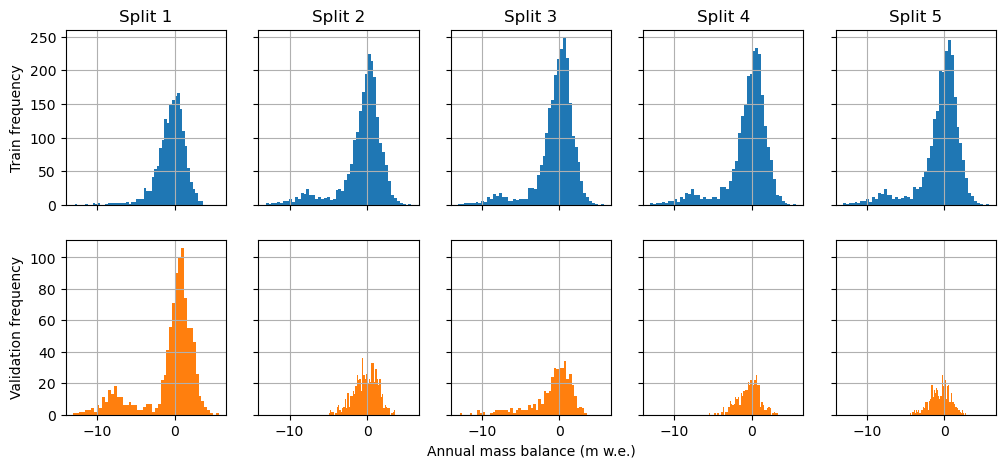

In [14]:
# Plot mass balance distributions of training and validation sets.
j=0
f, ax = plt.subplots(2, len(splits_s), figsize=(12,5), sharey='row', sharex='col')
for i in range(0,len(splits_s)):
    if i>2:
        j=1
    df_train_s.iloc[splits_s[i][0]].balance_netto.plot.hist(bins=50, ax=ax[0,i], color='C0')
    df_train_s.iloc[splits_s[i][1]].balance_netto.plot.hist(bins=50, ax=ax[1,i], color='C1')
    ax[0,i].set_title('Split '+str(i+1))

ax[0,0].set_ylabel('Train frequency')
ax[1,0].set_ylabel('Validation frequency')
ax[1,2].set_xlabel('Annual mass balance (m w.e.)')
    
for row in ax:
    for a in row:
        a.grid()

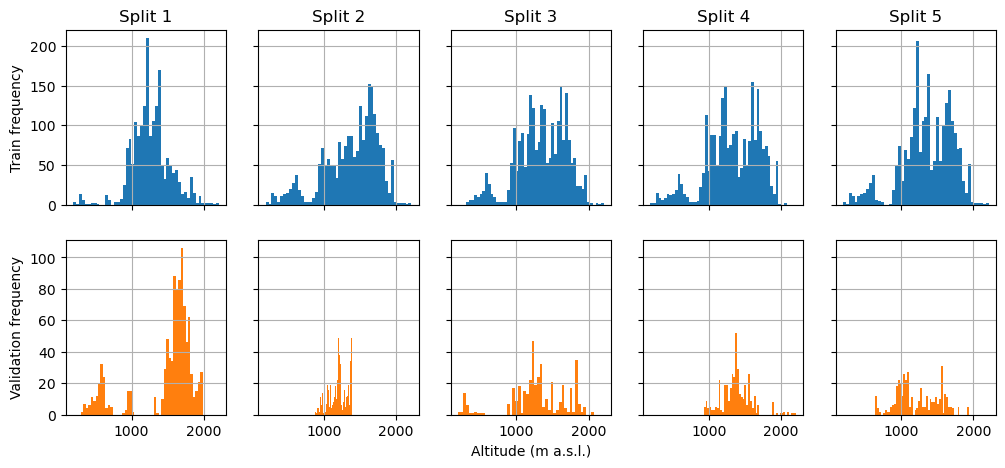

In [15]:
# Plot altitude distributions of training and validation sets.

j=0
f, ax = plt.subplots(2, len(splits_s), figsize=(12,5), sharey='row', sharex='col')
for i in range(0,len(splits_s)):
    if i>2:
        j=1
    df_train_s.iloc[splits_s[i][0]].altitude.plot.hist(bins=50, ax=ax[0,i], color='C0')
    df_train_s.iloc[splits_s[i][1]].altitude.plot.hist(bins=50, ax=ax[1,i], color='C1')
    ax[0,i].set_title('Split '+str(i+1))

ax[0,0].set_ylabel('Train frequency')
ax[1,0].set_ylabel('Validation frequency')
ax[1,2].set_xlabel('Altitude (m a.s.l.)')
    
for row in ax:
    for a in row:
        a.grid()

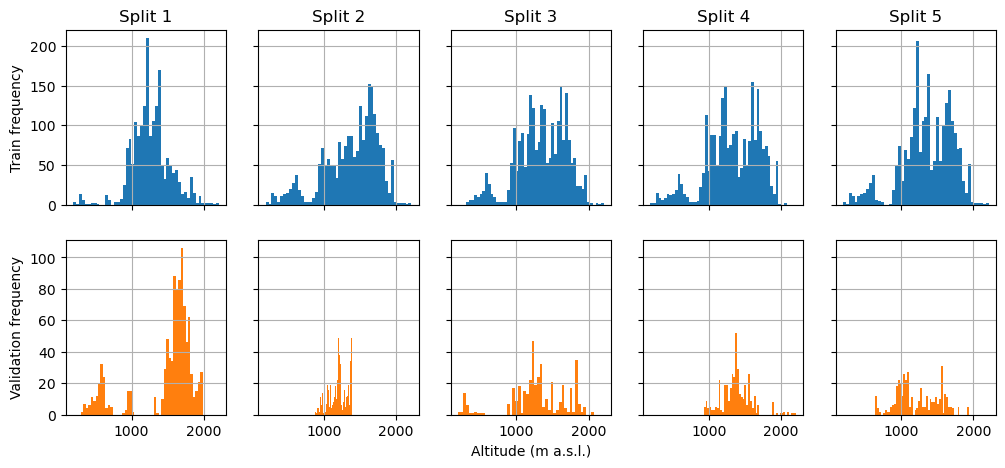

In [16]:
# CHECK THAT SPLITS ARE PERFORMED CORRECTLY

j=0
f, ax = plt.subplots(2, len(splits_s), figsize=(12,5), sharey='row', sharex='col')
for i in range(0,len(splits_s)):
    if i>2:
        j=1
    ax[0,i].hist(X_train_s[splits_s[i][0],0], bins=50, color='C0')
    ax[1,i].hist(X_train_s[splits_s[i][1],0], bins=50, color='C1')
    ax[0,i].set_title('Split '+str(i+1))

ax[0,0].set_ylabel('Train frequency')
ax[1,0].set_ylabel('Validation frequency')
ax[1,2].set_xlabel('Altitude (m a.s.l.)')
    
for row in ax:
    for a in row:
        a.grid()

### Train model

In [17]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -1.812597415700468
Grid search best hyperparameters:  {'learning_rate': 0.25, 'max_depth': 2, 'n_estimators': 400}
Cross validation scores per fold:  [-1.41662052 -1.79965491 -2.43753816 -0.74509215 -2.66408135]
Mean cross validation score:  -1.812597415700468
Standard deviation:  0.6945658390524949


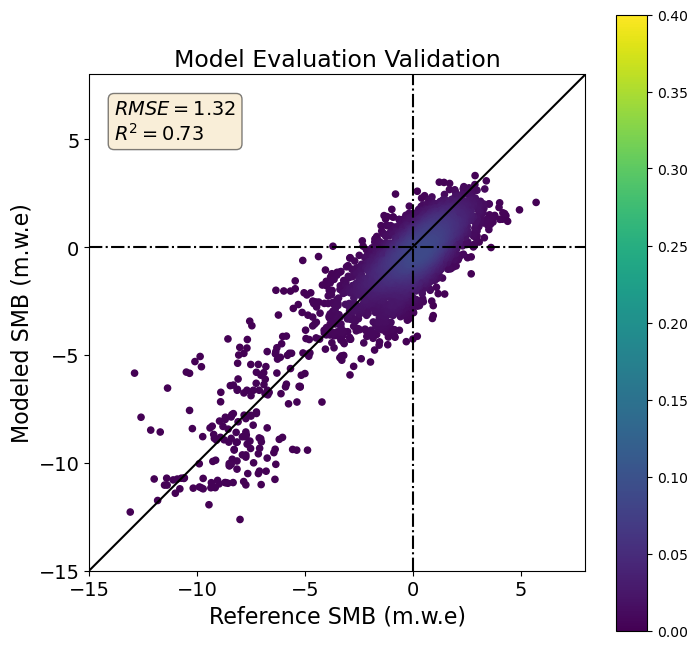

In [18]:
# Train model
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, scorer='neg_mean_squared_error')

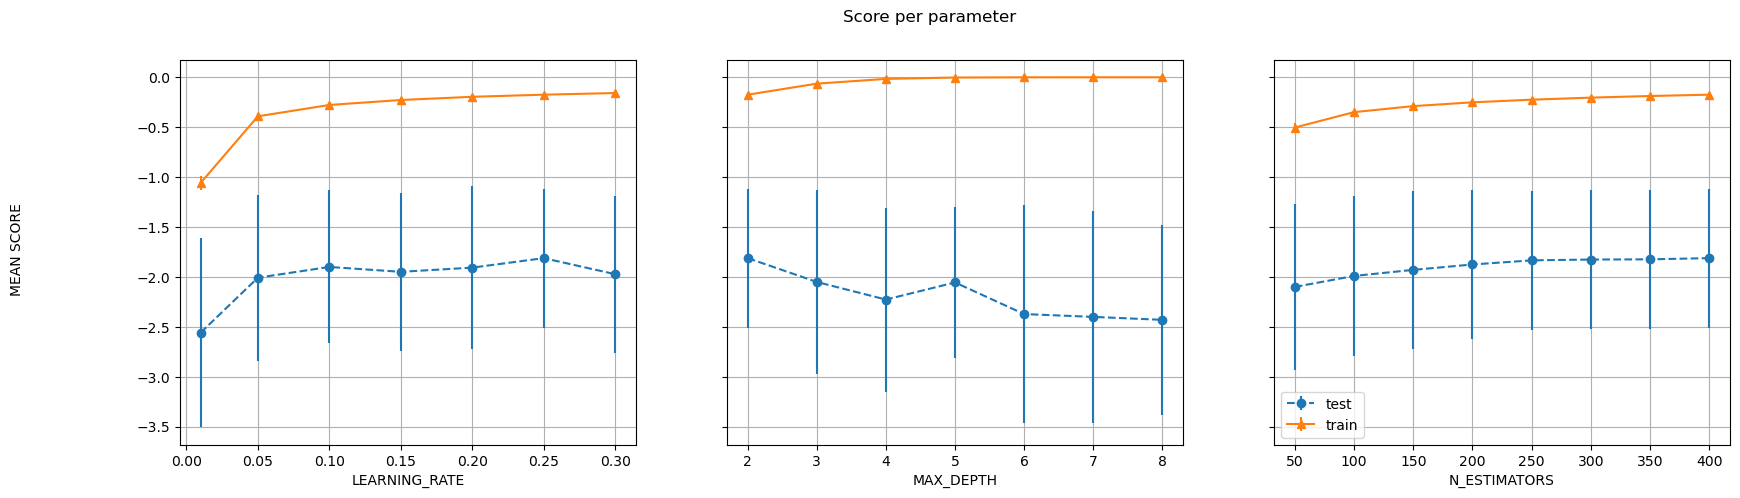

In [19]:
plot_gsearch_results(cv_grid)

In [20]:
# Save model
import joblib

# Save cv-object
joblib.dump(cv_grid, 'Models/cv_block_glacier_5fold_temp_prec_correct.pkl')
## joblib.load('/Models/cv_block_glacier_5fold_all_climate.pkl')

['Models/cv_block_glacier_5fold_temp_prec_correct.pkl']

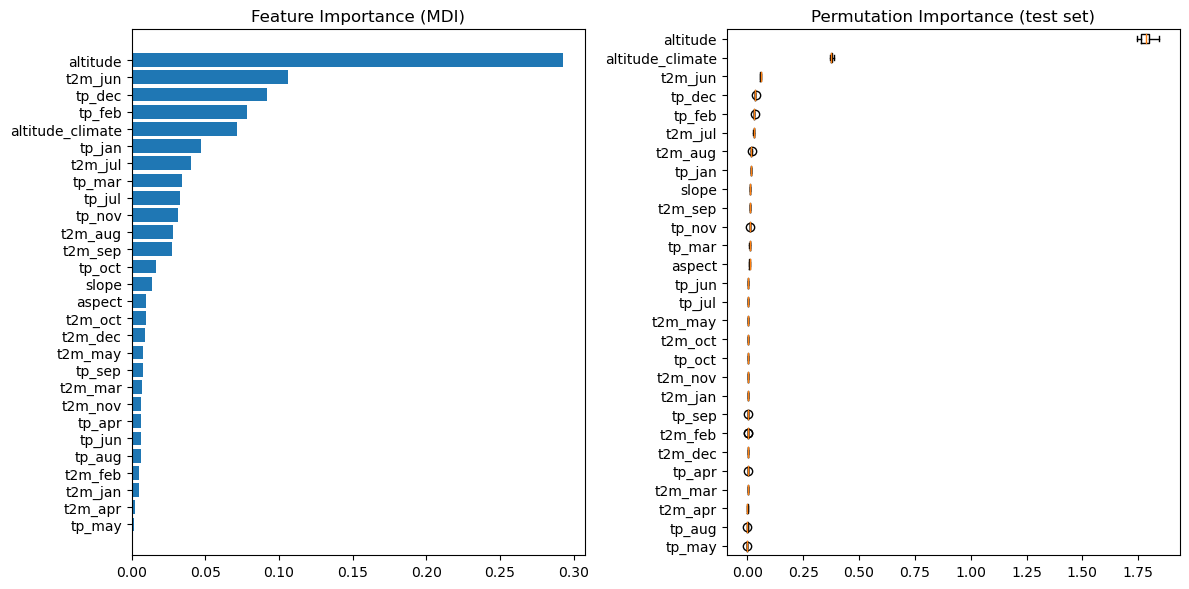

In [22]:
from sklearn.inspection import permutation_importance

best_model.fit(X_train_s, y_train_s)
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(df_train_X_s.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    best_model, X_train_s, y_train_s, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(df_train_X_s.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Training with only temperature, precipitation, topographical features and lat/lon

### Select features and prepare data for training

In [99]:
# Select features
base_cols = ['altitude','aspect','slope','altitude_climate','lat','lon']
temp_cols = ['t2m_oct','t2m_nov','t2m_dec','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_dec','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
label_cols = ['balance_netto']

In [100]:
# Shuffle training dataset in order to shuffle glaciers such that they do not appear in order of glacier ID
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [101]:
# Select features for training
df_train_X_s = select_variables(df_train_s, base_cols, temp_cols, prec_cols)

# Select labels for training
df_train_y_s = select_variables(df_train_s, label_cols)

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

### Train model

In [102]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -2.0982079379878336
Grid search best hyperparameters:  {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300}
Cross validation scores per fold:  [-1.78539102 -2.58960975 -2.30251971 -0.99102117 -2.82249804]
Mean cross validation score:  -2.0982079379878336
Standard deviation:  0.6529214564215243


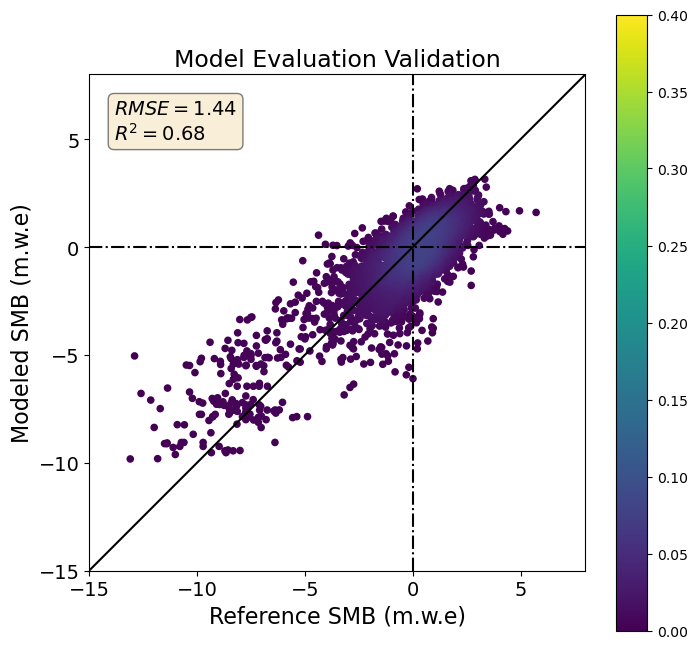

In [103]:
# Train model
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, scorer='neg_mean_squared_error')

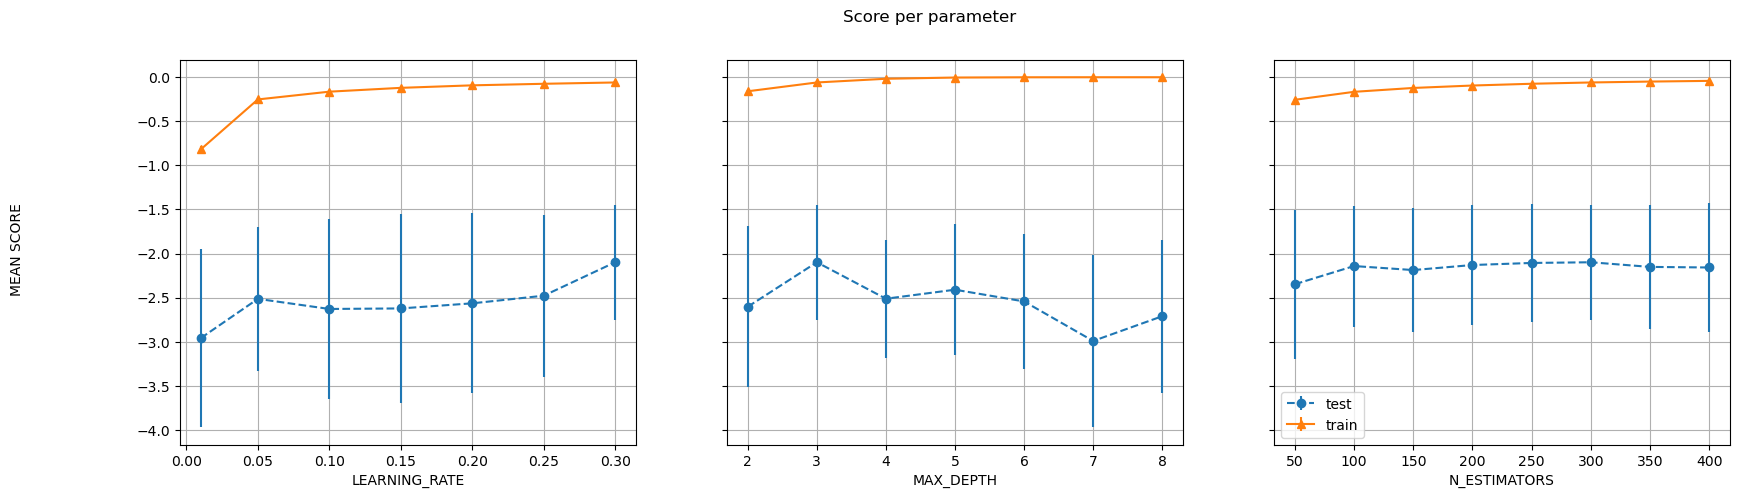

In [104]:
plot_gsearch_results(cv_grid)

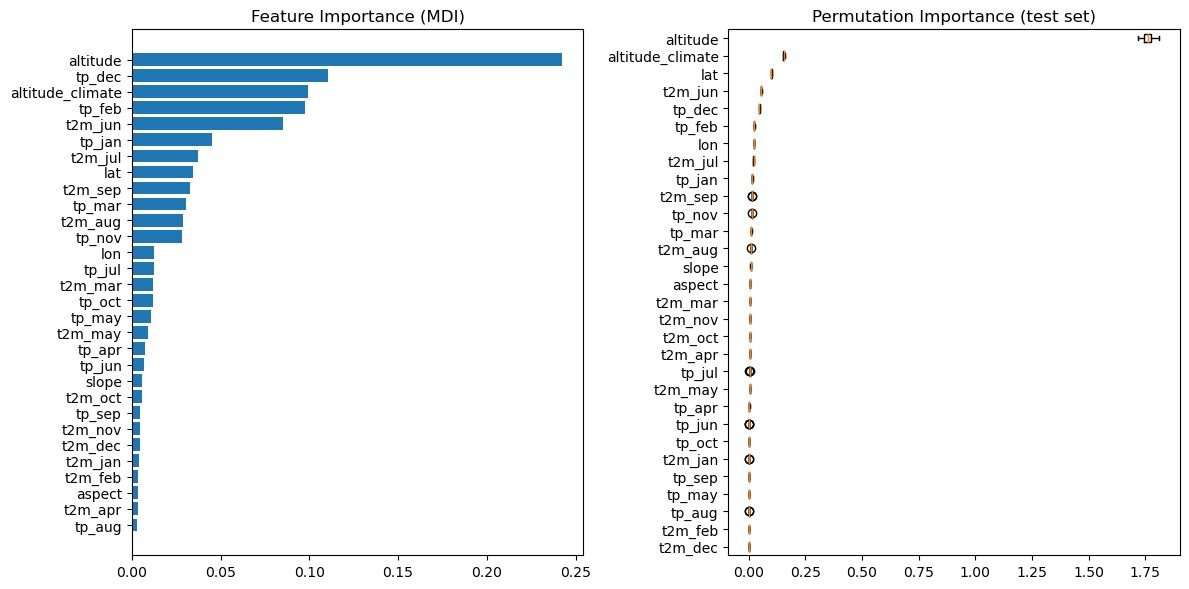

In [105]:
from sklearn.inspection import permutation_importance

best_model.fit(X_train_s, y_train_s)
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(df_train_X_s.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    best_model, X_train_s, y_train_s, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(df_train_X_s.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Training with all climate variables

### Select features and prepare data for training

In [23]:
# Select features to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat','lon','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation] for y in x]

In [24]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [25]:
# Select features for training
df_train_X_s = df_train_s.drop(drop_cols, axis=1)

# Select labels for training
df_train_y_s = df_train_s[['balance_netto']]

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

In [26]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

### Check previous mistake

In [27]:
df_train_X_test = df_train.drop(drop_cols, axis=1)
df_train_y_test = df_train[['balance_netto']]
X_train_test, y_train_test = df_train_X_test.values, df_train_y_test.values
splits_test = list(group_kf.split(X_train_test, y_train_test, gp_s))

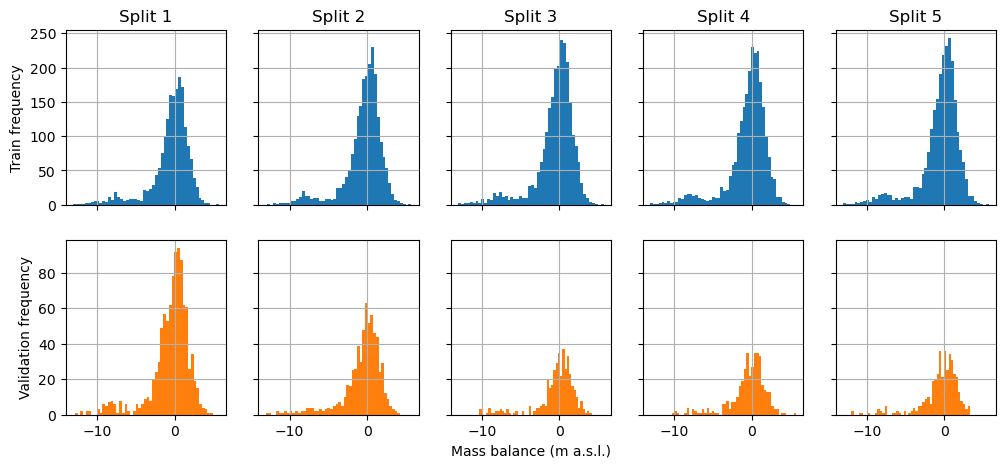

In [28]:
# CHECK THAT SPLITS ARE PERFORMED CORRECTLY

j=0
f, ax = plt.subplots(2, len(splits_test), figsize=(12,5), sharey='row', sharex='col')
for i in range(0,len(splits_test)):
    if i>2:
        j=1
    ax[0,i].hist(y_train_test[splits_test[i][0],0], bins=50, color='C0')
    ax[1,i].hist(y_train_test[splits_test[i][1],0], bins=50, color='C1')
    ax[0,i].set_title('Split '+str(i+1))

ax[0,0].set_ylabel('Train frequency')
ax[1,0].set_ylabel('Validation frequency')
ax[1,2].set_xlabel('Mass balance (m a.s.l.)')
    
for row in ax:
    for a in row:
        a.grid()

### Train model

In [29]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -2.070092462802099
Grid search best hyperparameters:  {'learning_rate': 0.25, 'max_depth': 2, 'n_estimators': 400}
Cross validation scores per fold:  [-1.2941395  -4.03113149 -1.91666816 -0.73793216 -2.370591  ]
Mean cross validation score:  -2.070092462802099
Standard deviation:  1.1257234589026834


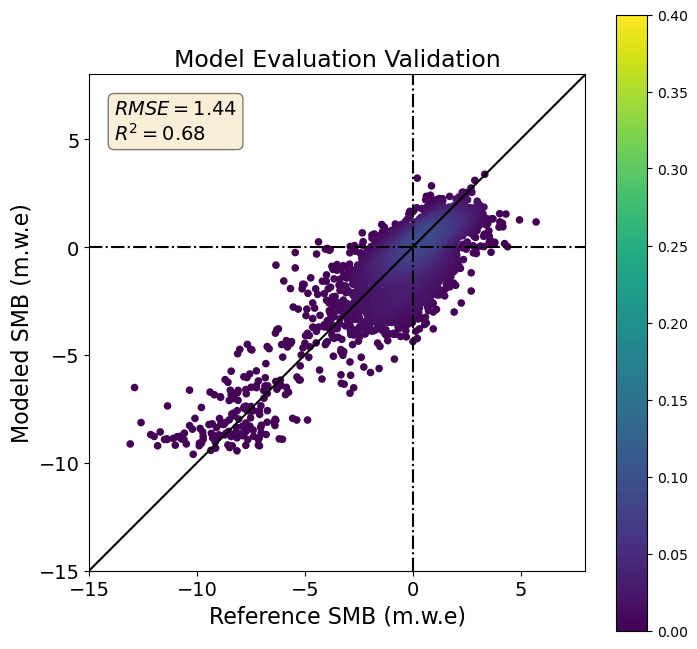

In [30]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

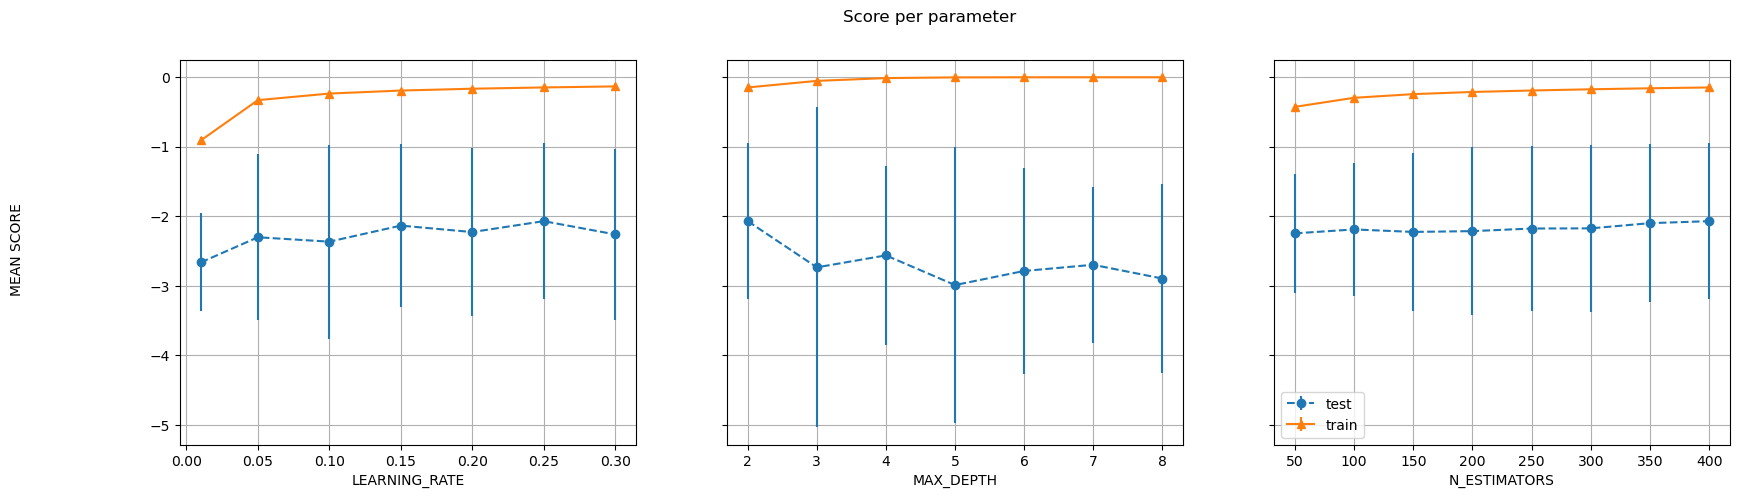

In [31]:
plot_gsearch_results(cv_grid)

In [32]:
# Save model

import joblib

# Save cv-object
joblib.dump(cv_grid, 'Models/cv_block_glacier_5fold_all_climate_correct.pkl')
## joblib.load('/Models/cv_block_glacier_5fold_all_climate.pkl')

['Models/cv_block_glacier_5fold_all_climate_correct.pkl']

In [18]:
#test = joblib.load('Models/cv_block_glacier_5fold_all_climate.pkl')
# fitted_model = xgb.XGBRegressor(learning_rate = test.best_params_['learning_rate'], 
#                                 n_estimators = test.best_params_['n_estimators'],
#                                 max_depth = test.best_params_['max_depth'])

In [33]:
# Plot feature importance

max_features_plot = 50

best_model.fit(X_train_s, y_train_s)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X_s.columns)[ind]

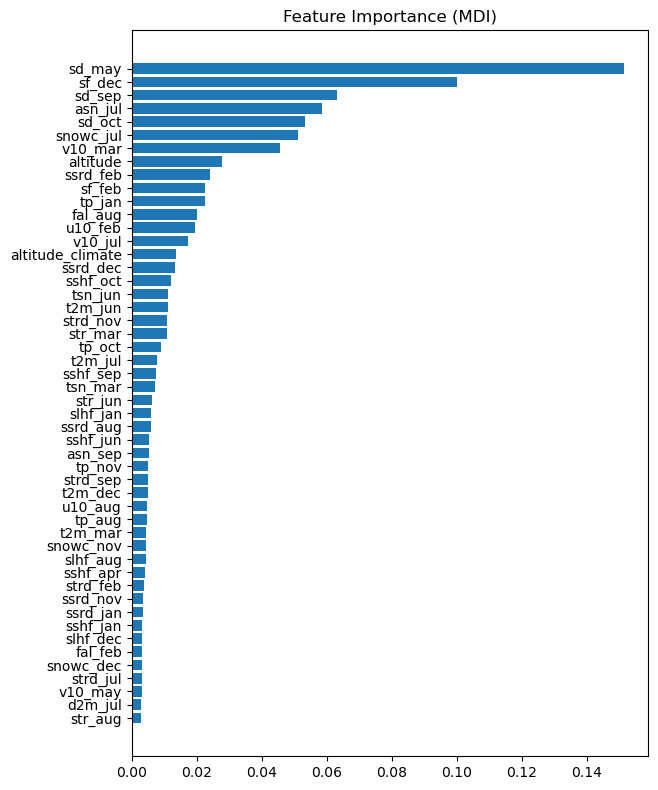

In [34]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## Train model with fewer (50) trees

In [19]:
# Performance with fewer trees
#best_model_few_trees = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, scorer='neg_mean_squared_error')

In [26]:
#model_fewer_trees = xgb.XGBRegressor(learning_rate = cv_grid.best_params_['learning_rate'], 
#                                     n_estimators = 50,
#                                     max_depth = cv_grid.best_params_['max_depth'])

In [5]:
#plot_prediction_per_fold(X_train_s, y_train_s, model_fewer_trees, splits_s)


# Train model without topographical features

### Select features and prepare data for training

In [42]:
# Select features to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat','lon','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
topo = ['altitude', 'slope', 'aspect', 'altitude_climate']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, topo] for y in x]

In [43]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [44]:
# Select features for training
df_train_X_s = df_train_s.drop(drop_cols, axis=1)

# Select labels for training
df_train_y_s = df_train_s[['balance_netto']]

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

In [45]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

### Train model

In [46]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -4.753576441975813
Grid search best hyperparameters:  {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 50}
Cross validation scores per fold:  [-11.05861759  -3.18518435  -4.86294983  -3.28907642  -1.37205402]
Mean cross validation score:  -4.753576441975813
Standard deviation:  3.3408027302314793


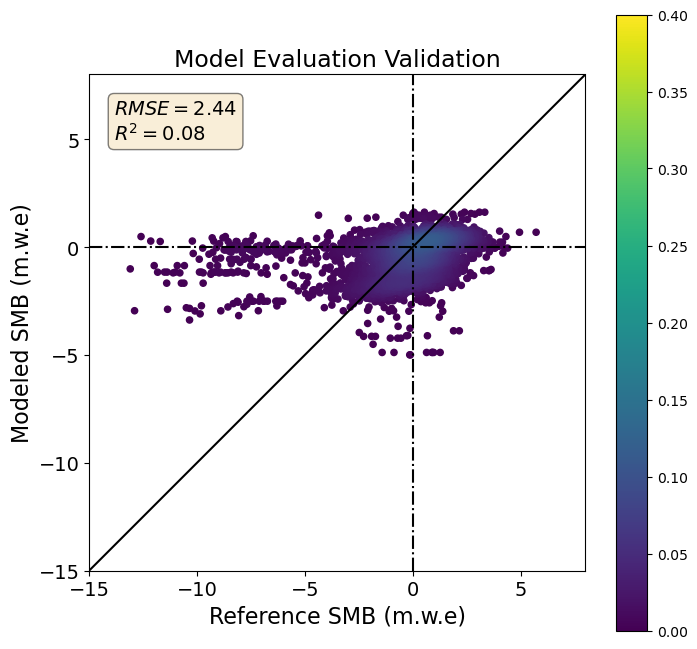

In [47]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

In [48]:
# Plot feature importance

max_features_plot = 50

best_model.fit(X_train_s, y_train_s)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X_s.columns)[ind]

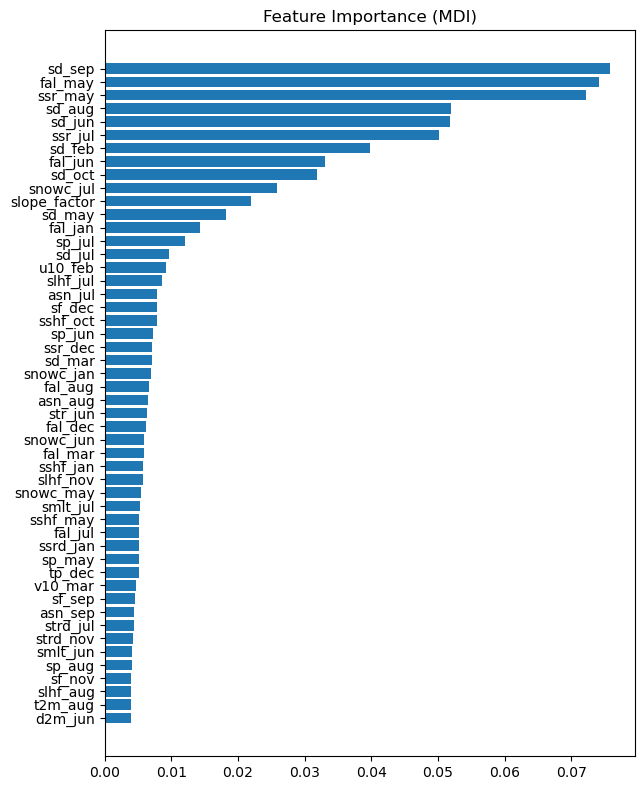

In [49]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Train model without derived climate variables

### Select features and prepare data for training

In [107]:
# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat','lon','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo] for y in x]

In [108]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [109]:
# Select features for training
df_train_X_s = df_train_s.drop(drop_cols, axis=1)

# Select labels for training
df_train_y_s = df_train_s[['balance_netto']]

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

In [110]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

### Train model

In [54]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -2.119711843792497
Grid search best hyperparameters:  {'learning_rate': 0.25, 'max_depth': 2, 'n_estimators': 400}
Cross validation scores per fold:  [-1.55841547 -3.28135071 -1.89860253 -1.10924469 -2.75094581]
Mean cross validation score:  -2.119711843792497
Standard deviation:  0.7915614949559926


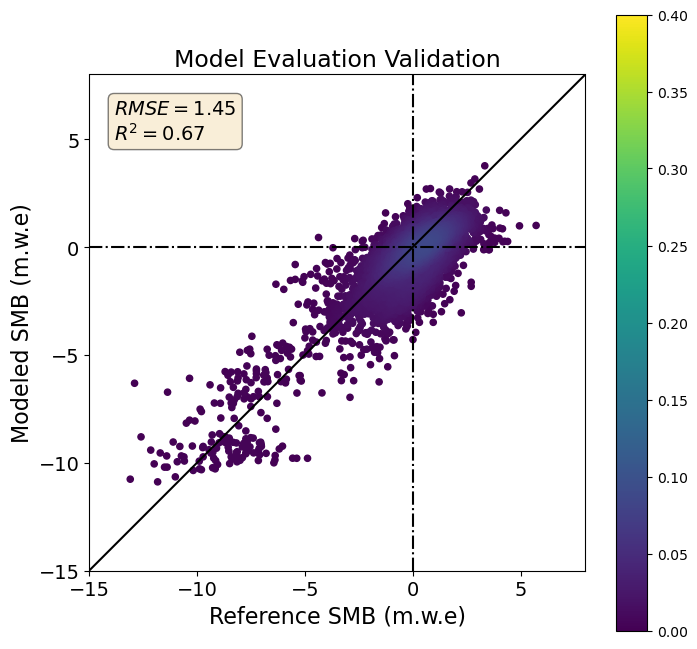

In [55]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

In [56]:
import joblib

# Save cv-object
joblib.dump(cv_grid, 'Models/cv_block_glacier_5fold_minimal_climate_correct.pkl')
# joblib.load('/Models/cv_block_glacier_5fold_all_climate.pkl')

['Models/cv_block_glacier_5fold_minimal_climate_correct.pkl']

In [57]:
# Plot feature importance

max_features_plot = 50

best_model.fit(X_train_s, y_train_s)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X_s.columns)[ind]

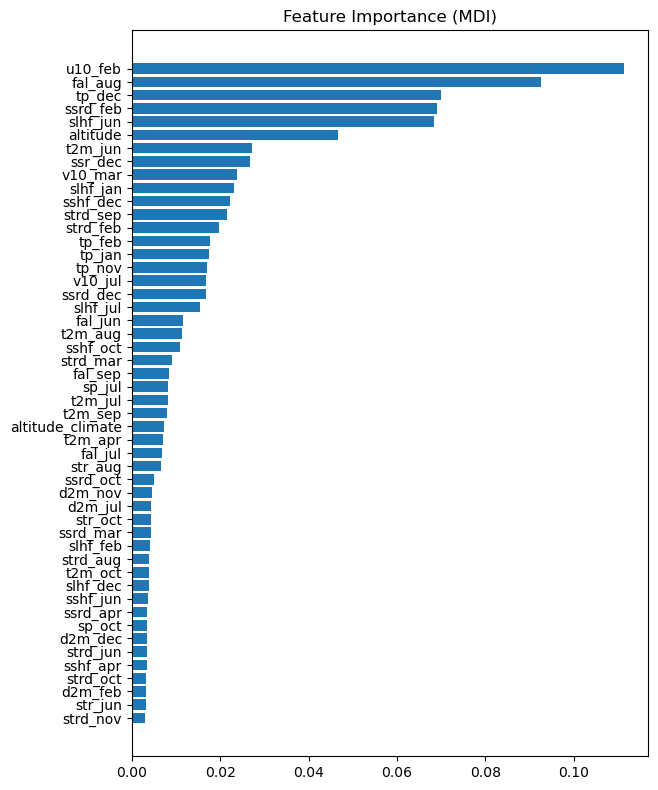

In [58]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

### Train model adjusting subsample

In [113]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
                'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
                'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
                'subsample': [0.5]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -1.932442052805147
Grid search best hyperparameters:  {'learning_rate': 0.25, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.5}
Cross validation scores per fold:  [-1.52824291 -3.43812087 -1.98267406 -1.0876122  -2.86462498]
Mean cross validation score:  -2.180255004483527
Standard deviation:  0.8612334298358499


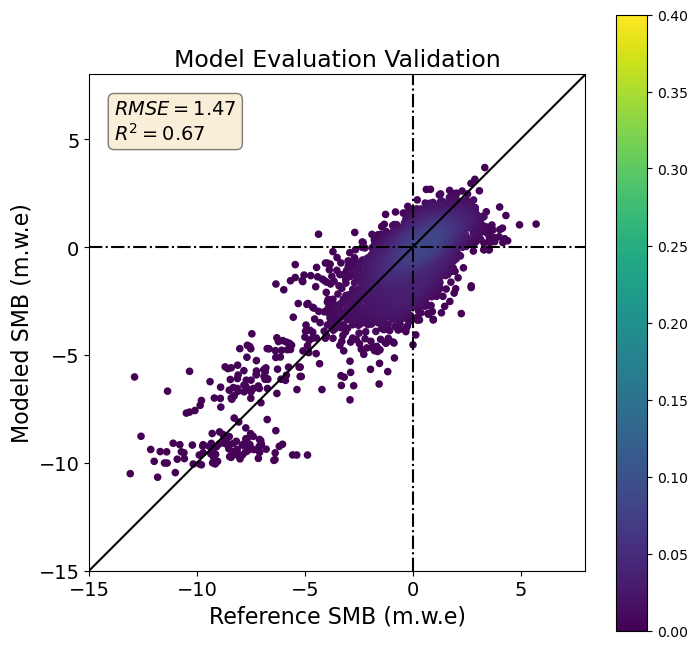

In [114]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

In [115]:
# Plot feature importance

max_features_plot = 50

best_model.fit(X_train_s, y_train_s)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X_s.columns)[ind]

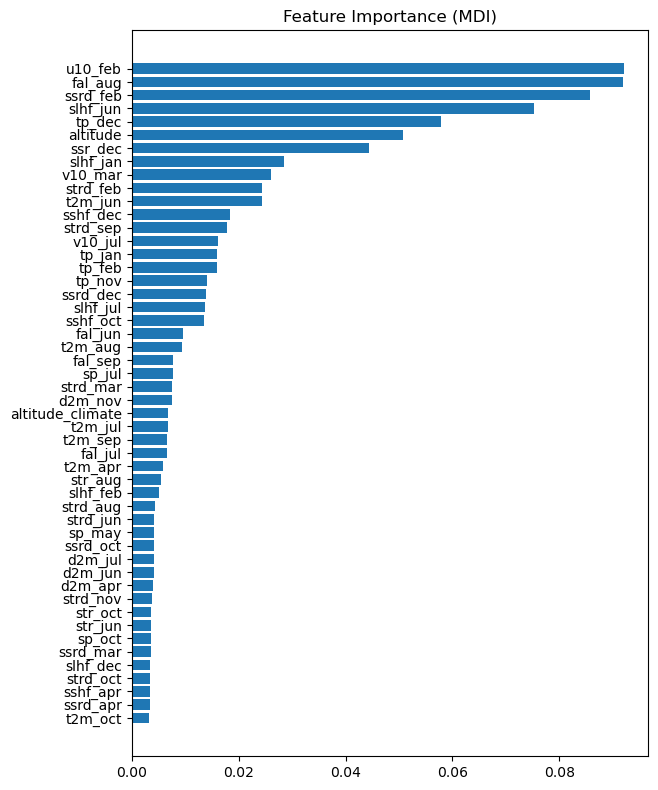

In [116]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

### Train model adjusting alpha and lambda

In [117]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
                'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
                'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
                'lambda': [10]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -2.105815578315301
Grid search best hyperparameters:  {'lambda': 10, 'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 200}
Cross validation scores per fold:  [-1.98501001 -3.56665351 -1.97316446 -1.00158883 -4.65854543]
Mean cross validation score:  -2.6369924474424176
Standard deviation:  1.3031684341660688


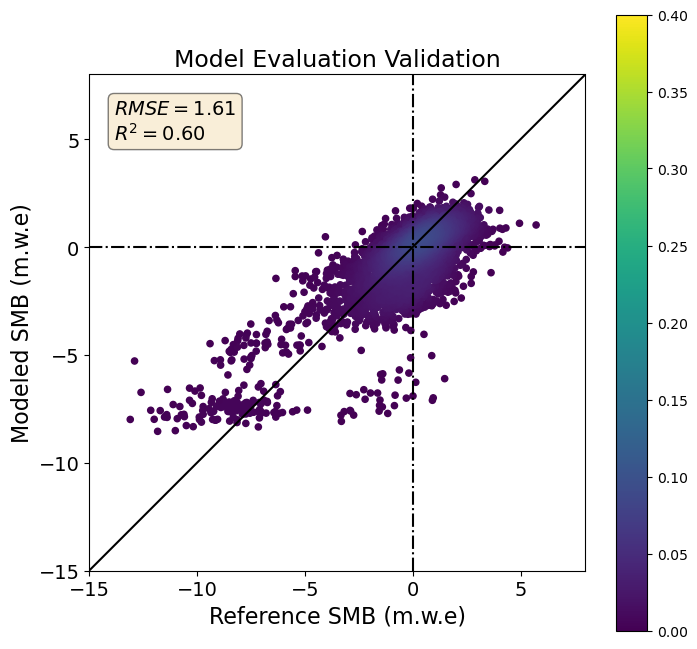

In [118]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

In [119]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
                'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
                'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
                'alpha': [10]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -2.2021508891760124
Grid search best hyperparameters:  {'alpha': 10, 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 400}
Cross validation scores per fold:  [-1.55957504 -4.31733613 -2.24989497 -1.27031806 -3.44887548]
Mean cross validation score:  -2.569199935822064
Standard deviation:  1.1522327389864493


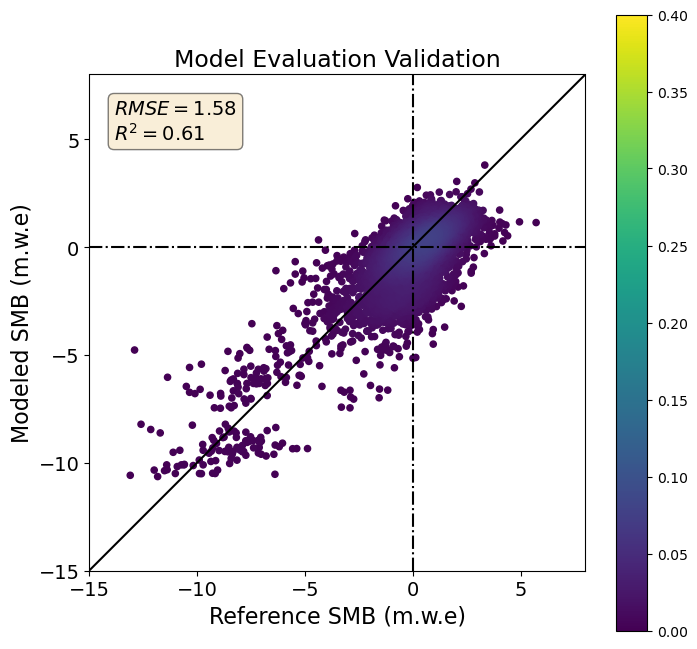

In [120]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

# Train model with max features including latitude and longitude


### Select features and prepare data for training

In [62]:
# Select columns to drop (lat and lon not dropped!)
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation] for y in x]

In [63]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [64]:
# Select features for training
df_train_X_s = df_train_s.drop(drop_cols, axis=1)

# Select labels for training
df_train_y_s = df_train_s[['balance_netto']]

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

In [65]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

### Train model

In [66]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -2.1076467579028337
Grid search best hyperparameters:  {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 150}
Cross validation scores per fold:  [-1.53401541 -2.82086933 -2.53309029 -0.88694817 -2.76331059]
Mean cross validation score:  -2.1076467579028337
Standard deviation:  0.7666474651058719


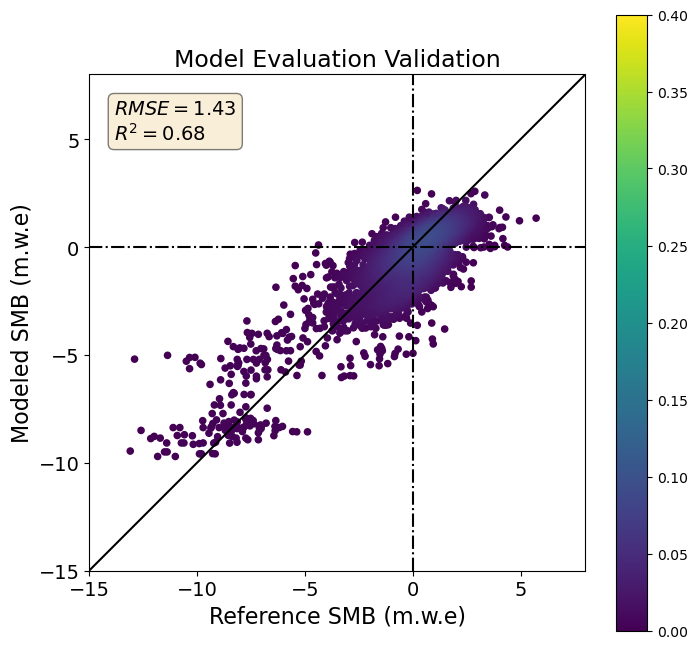

In [67]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

In [68]:
import joblib

# Save cv-object
joblib.dump(cv_grid, 'Models/cv_block_glacier_5fold_all_climate_latlon_correct.pkl')
# joblib.load('/Models/cv_block_glacier_5fold_all_climate.pkl')

['Models/cv_block_glacier_5fold_all_climate_latlon_correct.pkl']

In [69]:
# Plot feature importance

max_features_plot = 50

best_model.fit(X_train_s, y_train_s)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X_s.columns)[ind]

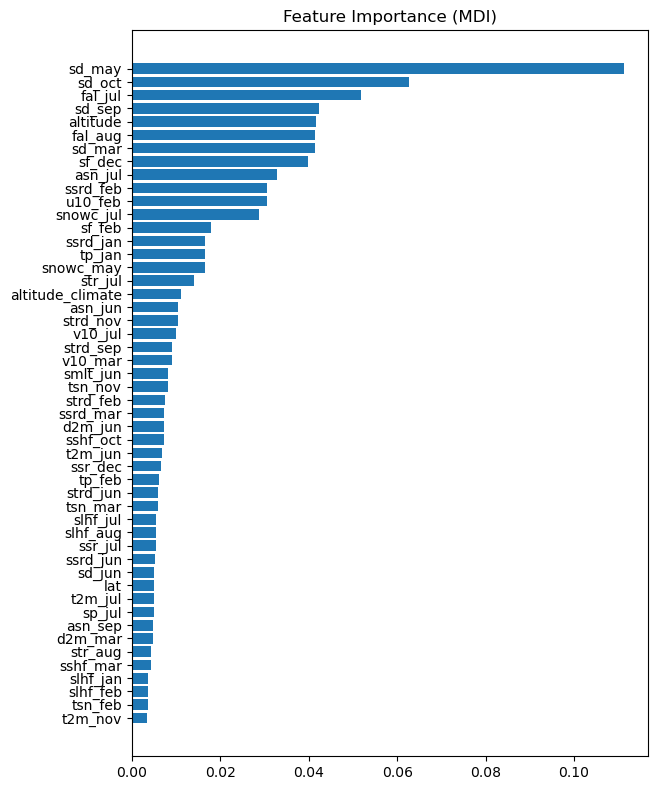

In [70]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Train model with minimual climate features, but including latitude and longitude

### Select features and prepare data for training

In [71]:
# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo] for y in x]


In [72]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [73]:
# Select features for training
df_train_X_s = df_train_s.drop(drop_cols, axis=1)

# Select labels for training
df_train_y_s = df_train_s[['balance_netto']]

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

In [74]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

### Train model

In [75]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -2.4139661751133348
Grid search best hyperparameters:  {'learning_rate': 0.25, 'max_depth': 7, 'n_estimators': 400}
Cross validation scores per fold:  [-2.55912286 -2.22438063 -2.05176646 -1.76214107 -3.47241986]
Mean cross validation score:  -2.4139661751133348
Standard deviation:  0.5887957111025028


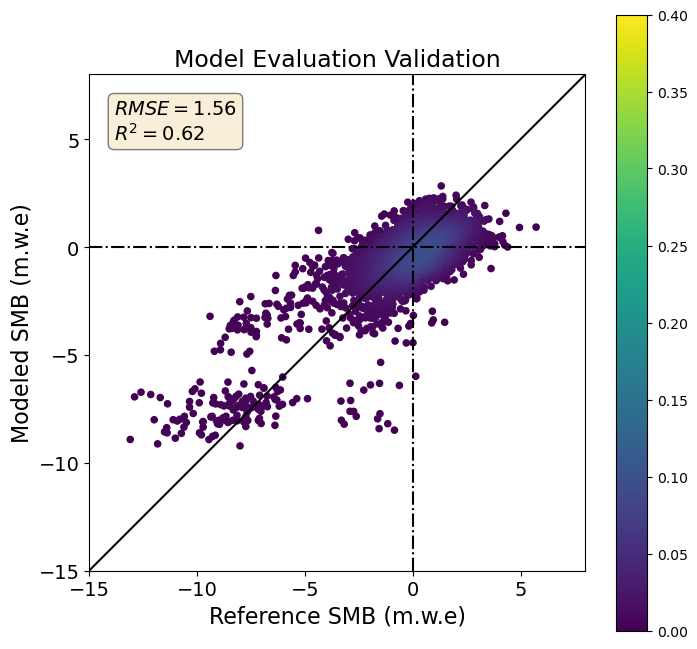

In [76]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

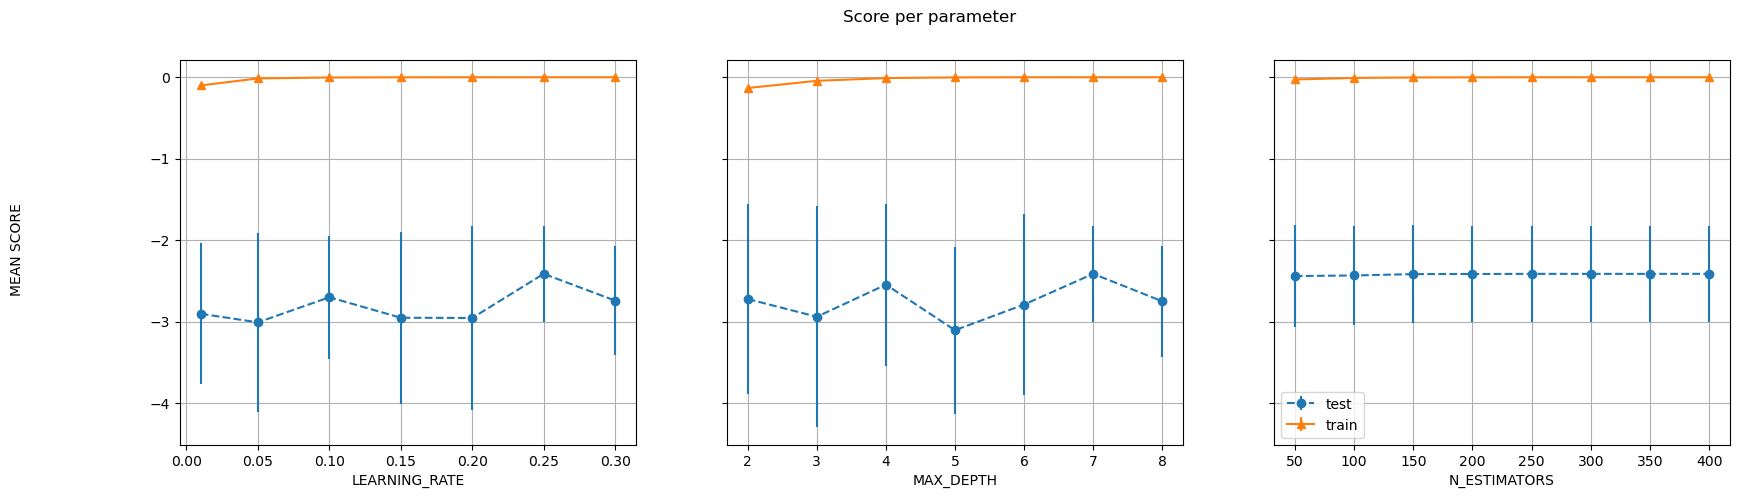

In [77]:
plot_gsearch_results(cv_grid)

### Train model with larger parameter ranges

In [81]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]}

In [82]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid_2, best_model_2, cvl_scores_2 = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

Fitting 5 folds for each of 630 candidates, totalling 3150 fits


KeyboardInterrupt: 

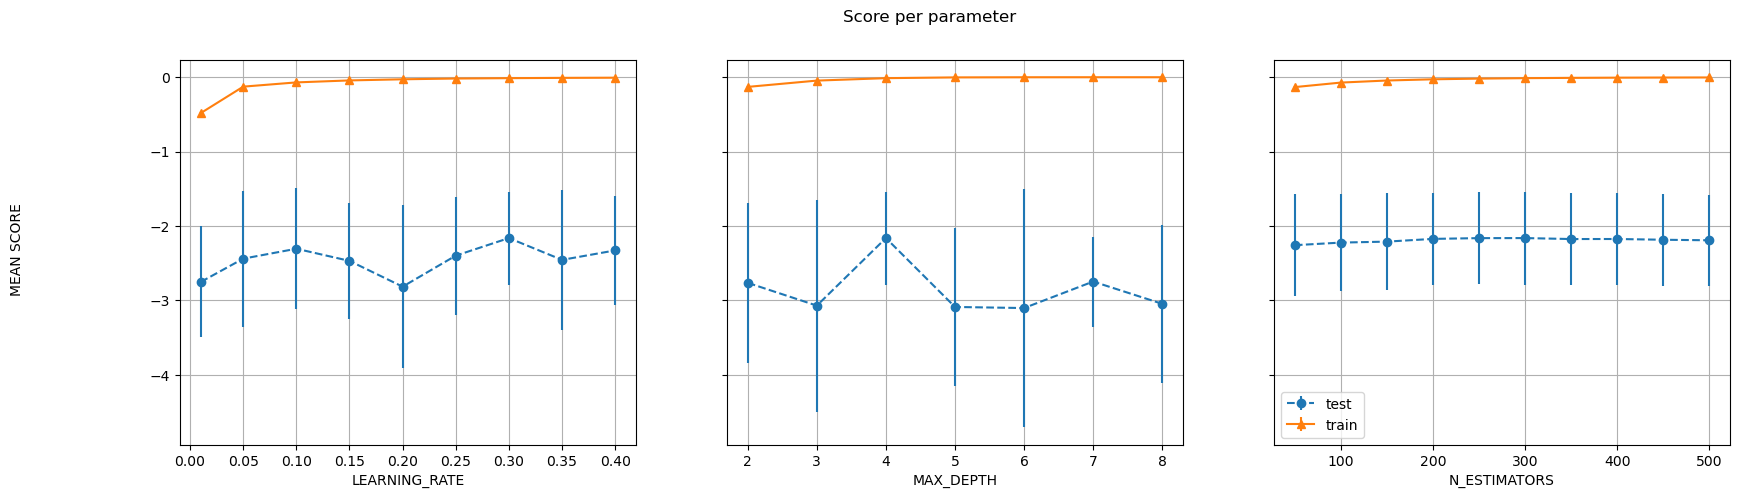

In [49]:
plot_gsearch_results(cv_grid_2)

In [79]:
import joblib

# Save cv-object
joblib.dump(cv_grid, 'Models/cv_block_glacier_5fold_minimal_climate_latlon_correct.pkl')
# joblib.load('/Models/cv_block_glacier_5fold_all_climate.pkl')

['Models/cv_block_glacier_5fold_minimal_climate_latlon_correct.pkl']

In [51]:
# Plot feature importance

max_features_plot = 50

best_model.fit(X_train_s, y_train_s)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X_s.columns)[ind]

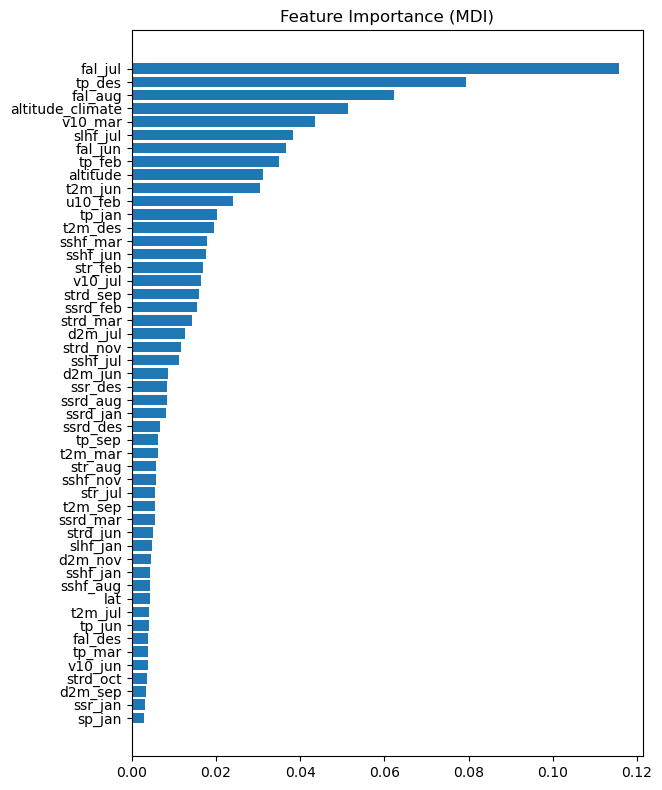

In [52]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Train model with reduced climate features, but including latitude and longitude

Include snow albedo and snowfall, since these seem to be important variables in the "all climate" models, and snow_temp. 

### Select features and prepare data for training

In [83]:
# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
#snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
#snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
#snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_melt] for y in x]

In [84]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [85]:
# Select features for training
df_train_X_s = df_train_s.drop(drop_cols, axis=1)

# Select labels for training
df_train_y_s = df_train_s[['balance_netto']]

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

In [86]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

### Train model

In [87]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -2.1983991911894476
Grid search best hyperparameters:  {'learning_rate': 0.25, 'max_depth': 4, 'n_estimators': 400}
Cross validation scores per fold:  [-1.92029059 -2.14967817 -2.4898414  -1.26764492 -3.16454089]
Mean cross validation score:  -2.1983991911894476
Standard deviation:  0.6267998055481427


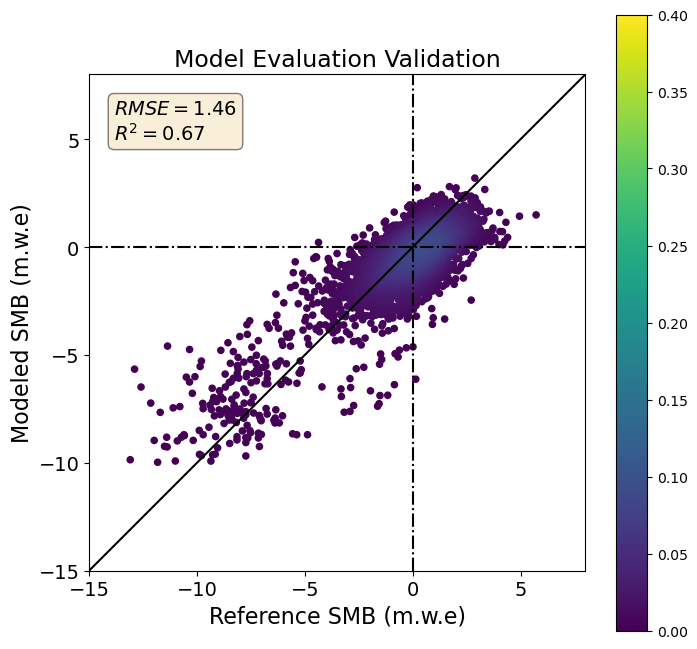

In [88]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

In [89]:
import joblib

# Save cv-object
joblib.dump(cv_grid, 'Models/cv_block_glacier_5fold_reduce_climate_latlon_correct.pkl')
# joblib.load('/Models/cv_block_glacier_5fold_all_climate.pkl')

['Models/cv_block_glacier_5fold_reduce_climate_latlon_correct.pkl']

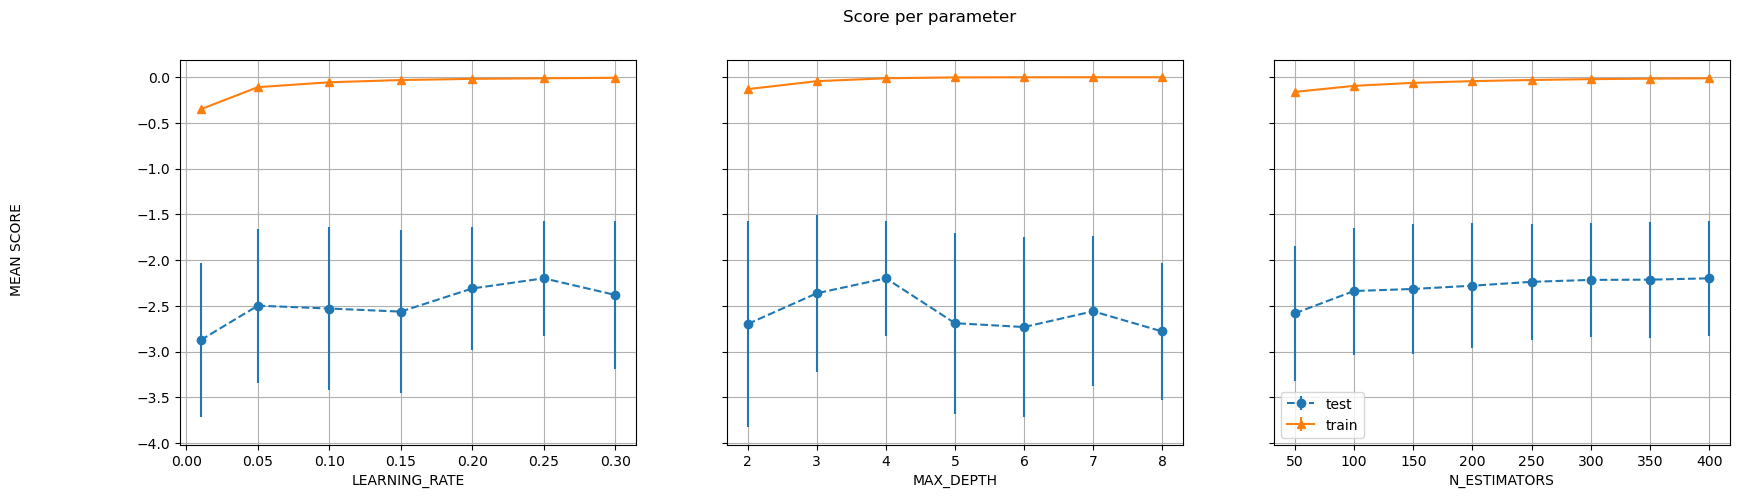

In [96]:
plot_gsearch_results(cv_grid)

In [106]:
# Plot feature importance

max_features_plot = 50

best_model.fit(X_train_s, y_train_s)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X_s.columns)[ind]

ValueError: kth(=-20) out of bounds (30)

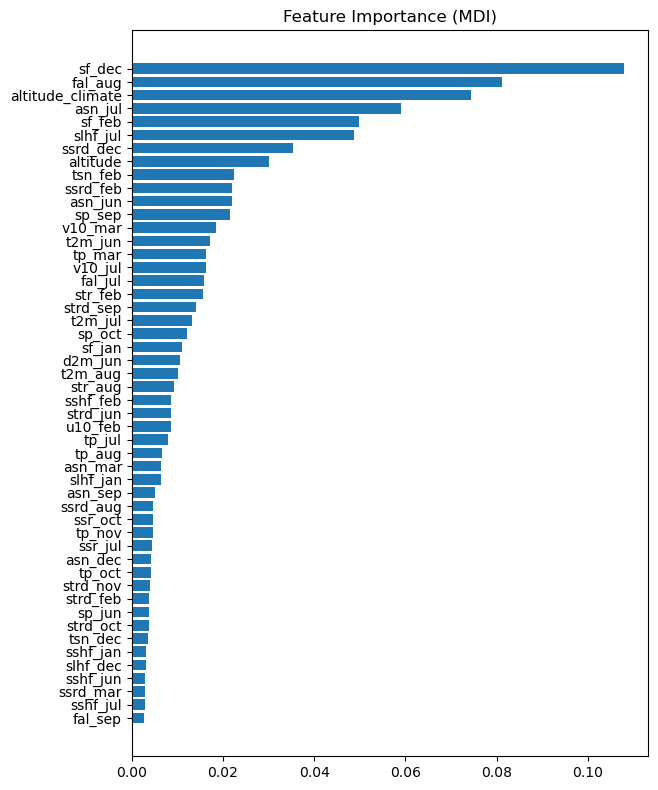

In [91]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Train model with reduced climate features, but including latitude and longitude AND EVAPORATION

Include snow albedo and snowfall, since these seem to be important variables in the "all climate" models, and snow_temp. 

### Select features and prepare data for training

In [92]:
# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
#evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
#snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
#snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
#snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, snow_cover, snow_depth_we, snow_melt] for y in x]

In [93]:
# Shuffle df_train, get X and y values
df_train_s = df_train.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [94]:
# Select features for training
df_train_X_s = df_train_s.drop(drop_cols, axis=1)

# Select labels for training
df_train_y_s = df_train_s[['balance_netto']]

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

In [95]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

### Train model

In [97]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -2.3304879139268984
Grid search best hyperparameters:  {'learning_rate': 0.25, 'max_depth': 3, 'n_estimators': 100}
Cross validation scores per fold:  [-1.85763146 -2.48226636 -2.80315332 -1.08161874 -3.42776969]
Mean cross validation score:  -2.3304879139268984
Standard deviation:  0.8042069400695862


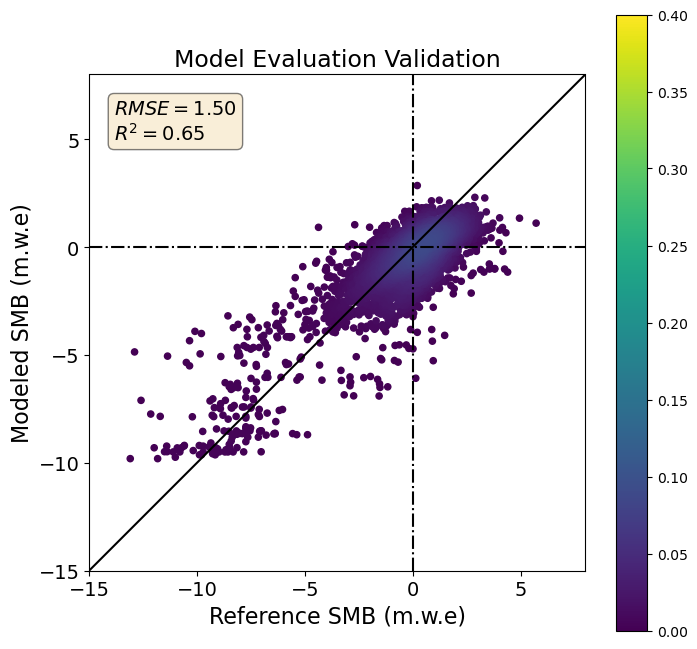

In [98]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)